# Определение перспективного тарифа для телеком компании

Имеем данные федерального оператора сотовой связи. Клиентам предлагают два тарифных плана: «Смарт» и «Ультра». Нужно понять, какой тариф приносит больше денег.

В выборке данные 500 пользователей оператора: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. Проанализируем поведение клиентов и сделаем вывод — какой тариф приносит больше прибыли.

## Описание тарифов

**Тариф «Смарт»**

1. Ежемесячная плата: 550 рублей
2. Включено 500 минут разговора, 50 сообщений и 15 Гб интернет-трафика
3. Стоимость услуг сверх тарифного пакета:
- минута разговора: 3 рубля
- сообщение: 3 рубля
- 1 Гб интернет-трафика: 200 рублей

**Тариф «Ультра»**

1. Ежемесячная плата: 1950 рублей
2. Включено 3000 минут разговора, 1000 сообщений и 30 Гб интернет-трафика
3. Стоимость услуг сверх тарифного пакета:
- минута разговора: 1 рубль
- сообщение: 1 рубль
- 1 Гб интернет-трафика: 150 рублей

**Важно**: Значения минут и мегабайтов всегда округляются в большую сторону. Если пользователь проговорил всего 1 секунду, в тарифе засчитывается целая минута.

**Описание данных**

Таблица `users` (информация о пользователях):

- `user_id` — уникальный идентификатор пользователя
- `first_name` — имя пользователя
- `last_name` — фамилия пользователя
- `age` — возраст пользователя (годы)
- `reg_date` — дата подключения тарифа (день, месяц, год)
- `churn_date` — дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных)
- `city` — город проживания пользователя
- `tariff` — название тарифного плана

Таблица `calls` (информация о звонках):

- `id` — уникальный номер звонка
- `call_date` — дата звонка
- `duration` — длительность звонка в минутах
- `user_id` — идентификатор пользователя, сделавшего звонок

Таблица `messages` (информация о сообщениях):

- `id` — уникальный номер сообщения
- `message_date` — дата сообщения
- `user_id` — идентификатор пользователя, отправившего сообщение

Таблица `internet` (информация об интернет-сессиях):

- `id` — уникальный номер сессии
- `mb_used` — объём потраченного за сессию интернет-трафика (в мегабайтах)
- `session_date` — дата интернет-сессии
- `user_id` — идентификатор пользователя

Таблица `tariffs` (информация о тарифах):

- `tariff_name` — название тарифа
- `rub_monthly_fee` — ежемесячная абонентская плата в рублях
- `minutes_included` — количество минут разговора в месяц, включённых в абонентскую плату
- `messages_included` — количество сообщений в месяц, включённых в абонентскую плату
- `mb_per_month_included` — объём интернет-трафика, включённого в абонентскую плату (в мегабайтах)
- `rub_per_minute` — стоимость минуты разговора сверх тарифного пакета (например, если в тарифе 100 минут разговора в месяц, то со 101 минуты будет взиматься плата)
- `rub_per_message` — стоимость отправки сообщения сверх тарифного пакета
- `rub_per_gb` — стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета (1 гигабайт = 1024 мегабайта)

**Структура работы**

1. [Загрузка данных и первый взгляд](#data_import)
    - [Вывод](#sum_up_1) 
2. [Предобработка данных](#data_processing)
    - [Вывод](#sum_up_2)
3. [Исследовательский анализ данных](#data_analysis)
    - [Вывод](#sum_up_3)
4. [Проверка гипотез](#hypotheses)
    - [Вывод](#sum_up_4)
5. [Общий вывод](#sum_up)

<a id="data_import"></a>
## Загрузка данных и первый взгляд

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from scipy import stats as st

In [2]:
users = pd.read_csv('/datasets/users.csv')
calls = pd.read_csv('/datasets/calls.csv')
messages = pd.read_csv('/datasets/messages.csv')
internet = pd.read_csv('/datasets/internet.csv')
tariffs = pd.read_csv('/datasets/tariffs.csv')

In [3]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
user_id       500 non-null int64
age           500 non-null int64
churn_date    38 non-null object
city          500 non-null object
first_name    500 non-null object
last_name     500 non-null object
reg_date      500 non-null object
tariff        500 non-null object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


Типы данных определились адекватно переменным. Пропущены значения только в столбце `churn_date`, что означает клиентов, которые продолжают пользоваться услугами оператора.

In [4]:
users.head()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


В каждой таблице проверим временной период, который охватывают наблюдения. Это пригодится на стадии объединения данных.

In [5]:
users['reg_date'] = pd.to_datetime(users['reg_date'],format='%Y-%m-%d')
users['reg_date'].min(), users['reg_date'].max()

(Timestamp('2018-01-01 00:00:00'), Timestamp('2018-12-31 00:00:00'))

In [6]:
calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
id           202607 non-null object
call_date    202607 non-null object
duration     202607 non-null float64
user_id      202607 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


In [7]:
calls.head()

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000


In [8]:
calls['call_date'] = pd.to_datetime(calls['call_date'],format='%Y-%m-%d')

In [9]:
calls['call_date'].min(), calls['call_date'].max()

(Timestamp('2018-01-01 00:00:00'), Timestamp('2018-12-31 00:00:00'))

Пропущенных значений нет, но встречаются звонки с нулевой длительностью. Это могут быть пропущенные звонки.

In [10]:
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
id              123036 non-null object
message_date    123036 non-null object
user_id         123036 non-null int64
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


In [11]:
messages.head()

,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000


In [12]:
messages['message_date'] = pd.to_datetime(messages['message_date'],format='%Y-%m-%d')
messages['message_date'].min(), messages['message_date'].max()

(Timestamp('2018-01-02 00:00:00'), Timestamp('2018-12-31 00:00:00'))

In [13]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
Unnamed: 0      149396 non-null int64
id              149396 non-null object
mb_used         149396 non-null float64
session_date    149396 non-null object
user_id         149396 non-null int64
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB


In [14]:
del internet['Unnamed: 0']

In [15]:
internet.head()

,id,mb_used,session_date,user_id
0,1000_0,112.95,2018-11-25,1000
1,1000_1,1052.81,2018-09-07,1000
2,1000_2,1197.26,2018-06-25,1000
3,1000_3,550.27,2018-08-22,1000
4,1000_4,302.56,2018-09-24,1000


In [16]:
internet.describe()

,mb_used,user_id
count,149396.000000,149396.000000
mean,370.192426,1252.099842
std,278.300951,144.050823
min,0.000000,1000.000000
25%,138.187500,1130.000000
50%,348.015000,1251.000000
75%,559.552500,1380.000000
max,1724.830000,1499.000000


In [17]:
internet['session_date'] = pd.to_datetime(internet['session_date'],format='%Y-%m-%d')
internet['session_date'].min(), internet['session_date'].max()

(Timestamp('2018-01-01 00:00:00'), Timestamp('2018-12-31 00:00:00'))

Встречаются нули в использованном трафике. Трафик может не учитываться, когда клиенты заходят на сайт оператора или пользуются безлимитными пакетами для отдельных сервисов (стриминг музыки, видео и т.п.).

In [18]:
tariffs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
messages_included        2 non-null int64
mb_per_month_included    2 non-null int64
minutes_included         2 non-null int64
rub_monthly_fee          2 non-null int64
rub_per_gb               2 non-null int64
rub_per_message          2 non-null int64
rub_per_minute           2 non-null int64
tariff_name              2 non-null object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


In [19]:
tariffs.head()

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


<a id="sum_up_1"></a>
**Вывод**

- Пропущенные данные, которые необходимо заполнить, отсутствуют
- Продолжительность звонков и интернет сессии бывают нулевыми, такие наблюдения можно удалить
- Все даты преобразованы в формат datetime
- Период наблюдений укладывается в 2018 год

<a id="data_processing"></a>
## Предобработка данных

Создадим заготовку для общей базы данных: для каждого пользователя нужно предоставить количество строк равное количеству месяцев, которое он пользовался связью в отчетном году. Сделаем это в два этапа. Сначала создадим таблицу `months`, где каждому пользователю будут соответствовать 12 строк с месяцами за 2018 год. Затем оставим для каждого пользователя строки только с теми месяцами, в которых он был клиентом (то есть отбросим месяца до заключения договора с оператором и месяца после расторжения, если оно имело место быть).

In [20]:
users['reg_month'] = users['reg_date'].dt.month
users['churn_date'] = pd.to_datetime(users['churn_date'],format='%Y-%m-%d')
users['churn_month'] = users['churn_date'].dt.month
users['churn_month'] = users['churn_month'].fillna(123)

Пропущенные значения в `churn_month` заполним маркером `123`, чтобы в дальнейшем можно было применить фильтрацию по таблице.

In [21]:
months = pd.DataFrame({'month': np.sort(users['reg_month'].unique())}) 

In [22]:
len(users) * len(months)

6000

In [23]:
users['key'] = 1
months['key'] = 1
report = months.merge(users, on='key')
len(report)

6000

In [24]:
report.head()

,month,key,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,reg_month,churn_month
0,1,1,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,5,123.0
1,1,1,1001,41,NaT,Москва,Иван,Ежов,2018-11-01,smart,11,123.0
2,1,1,1002,59,NaT,Стерлитамак,Евгений,Абрамович,2018-06-17,smart,6,123.0
3,1,1,1003,23,NaT,Москва,Белла,Белякова,2018-08-17,ultra,8,123.0
4,1,1,1004,68,NaT,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra,5,123.0


In [25]:
len(report)

6000

In [26]:
report = report[(report['month'] >= report['reg_month']) & (report['month'] <= report['churn_month'])]

In [27]:
len(report)

3216

In [28]:
calls.head()

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000


Теперь можем посчитать новые переменные для каждого пользователя:

- количество сделанных звонков и израсходованных минут разговора по месяцам;
- количество отправленных сообщений по месяцам;
- объем израсходованного интернет-трафика по месяцам;
- помесячную выручку с каждого пользователя.

In [29]:
calls['duration_full'] = calls['duration'].apply(np.ceil)
calls['month'] = calls['call_date'].dt.month
calls_gr = calls.groupby(['user_id', 'month'])['duration_full'].agg('sum').reset_index()

In [30]:
calls['duration_full'].sum(), calls_gr['duration_full'].sum()

(1450301.0, 1450301.0)

In [31]:
report = report.merge(calls_gr, how='left', on=['user_id', 'month'])

In [32]:
report['duration_full'].sum()

1450301.0

In [33]:
report[report['user_id'] == 1000]

,month,key,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,reg_month,churn_month,duration_full
406,5,1,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,5,123.0,159.0
614,6,1,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,5,123.0,172.0
862,7,1,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,5,123.0,340.0
1154,8,1,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,5,123.0,408.0
1496,9,1,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,5,123.0,466.0
1871,10,1,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,5,123.0,350.0
2288,11,1,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,5,123.0,338.0
2738,12,1,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,5,123.0,333.0


In [34]:
internet.head(1)

,id,mb_used,session_date,user_id
0,1000_0,112.95,2018-11-25,1000


In [35]:
internet['mb_used_full'] = internet['mb_used'].apply(np.ceil)
internet['month'] = internet['session_date'].dt.month
inet_gr = internet.groupby(['user_id', 'month'])['mb_used_full'].agg('sum').reset_index()

In [36]:
internet['mb_used_full'].sum(), inet_gr['mb_used_full'].sum()

(55369459.0, 55369459.0)

In [37]:
report = report.merge(inet_gr, how='left', on=['user_id', 'month'])
report['mb_used_full'].sum()

55369459.0

In [38]:
messages['month'] = messages['message_date'].dt.month
msg_gr = messages.groupby(['user_id', 'month'])['id'].agg('count').reset_index()
msg_gr.columns = ['user_id', 'month', 'msg_count']

In [39]:
len(messages), msg_gr['msg_count'].sum()

(123036, 123036)

In [40]:
report = report.merge(msg_gr, how='left', on=['user_id', 'month'])
report['msg_count'].sum()

123036.0

In [41]:
report.head()

,month,key,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,reg_month,churn_month,duration_full,mb_used_full,msg_count
0,1,1,1005,67,NaT,Набережные Челны,Афанасий,Горлов,2018-01-25,smart,1,123.0,95.0,2730.0,7.0
1,1,1,1032,31,NaT,Ульяновск,Инна,Игнатьева,2018-01-04,smart,1,123.0,380.0,24147.0,38.0
2,1,1,1045,48,NaT,Улан-Удэ,Джемма,Карасева,2018-01-30,smart,1,123.0,9.0,2348.0,5.0
3,1,1,1055,39,NaT,Казань,Луиза,Березина,2018-01-02,smart,1,123.0,551.0,17111.0,30.0
4,1,1,1071,20,2018-08-31,Омск,Гектор,Чумаков,2018-01-09,smart,1,8.0,194.0,15622.0,16.0


In [42]:
tariffs = tariffs.rename(columns={'tariff_name': 'tariff'})

In [43]:
report = report.merge(tariffs, how='left', on='tariff')

In [44]:
del report['key']

In [45]:
report.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3216 entries, 0 to 3215
Data columns (total 21 columns):
month                    3216 non-null int64
user_id                  3216 non-null int64
age                      3216 non-null int64
churn_date               189 non-null datetime64[ns]
city                     3216 non-null object
first_name               3216 non-null object
last_name                3216 non-null object
reg_date                 3216 non-null datetime64[ns]
tariff                   3216 non-null object
reg_month                3216 non-null int64
churn_month              3216 non-null float64
duration_full            3174 non-null float64
mb_used_full             3203 non-null float64
msg_count                2717 non-null float64
messages_included        3216 non-null int64
mb_per_month_included    3216 non-null int64
minutes_included         3216 non-null int64
rub_monthly_fee          3216 non-null int64
rub_per_gb               3216 non-null int64
rub_per_m

In [46]:
def revenue(row):
    res = row['rub_monthly_fee']
    if row['duration_full'] > row['minutes_included']:
        res += (row['duration_full'] - row['minutes_included']) * row['rub_per_minute']
    if row['msg_count'] > row['messages_included']:
        res += (row['msg_count'] - row['messages_included']) * row['rub_per_message']
    if row['mb_used_full'] > row['mb_per_month_included']:
        res += np.ceil((row['mb_used_full'] - row['mb_per_month_included']) / 1024) * row['rub_per_gb']
    return res

In [47]:
report['revenue'] = report.apply(revenue, axis=1)

In [48]:
len(report), len(report['user_id'].unique())

(3216, 500)

In [49]:
len(report[(report['revenue'] != 550) & (report['revenue'] != 1950)]),\
len(report[(report['revenue'] != 550) & (report['revenue'] != 1950)]['user_id'].unique())

(1748, 376)

In [50]:
1748 / 3216 * 100

54.353233830845774

In [51]:
376 / 500 * 100

75.2

<a id="sum_up_2"></a>
**Вывод**

- Подготовили общую базу для отчетов, добавили в нее сводные месячные данные каждого пользователя по длительности исходящих звонков, количеству отправленных сообщений, израсходованному трафику, а также помесячную выручку
- 45,65% месяцев в базе клиентам хватало базового пакета по тарифу, при этом только 24,8% пользователей ни разу за год не превышали тарифные лимиты.

<a id="data_analysis"></a>
## Исследовательский анализ данных

Опишем поведение клиентов оператора, исходя из выборки. Сколько минут разговора, сколько сообщений и какой объём интернет-трафика требуется пользователям каждого тарифа в месяц?

Сводная таблица по израсходованным минутам на исходящие звонки:

In [52]:
pivot_calls = report.pivot_table(index='tariff', values='duration_full',
                                 aggfunc=['count', 'median', 'mean', np.var, np.std])
pivot_calls.columns = ['count', 'median', 'mean', 'variance', 'std']
pivot_calls

,count,median,mean,variance,std
tariff,,,,,
smart,2223,423.0,419.062978,35844.189551,189.325618
ultra,951,528.0,545.451104,94203.418396,306.925754


На тарифе `ultra` стандартное отклонение значительно выше, чем на тарифе `smart`. Большому количеству пользователей тарифа `ultra` хватило бы пакета минут с тарифа `smart`.

Сводная таблица по отправленным сообщениям:

In [53]:
pivot_msg = report.pivot_table(index='tariff', values='msg_count',
                               aggfunc=['count', 'median', 'mean', np.var, np.std])
pivot_msg.columns = ['count', 'median', 'mean', 'variance', 'std']
pivot_msg

,count,median,mean,variance,std
tariff,,,,,
smart,1922,34.0,38.716441,717.594201,26.787949
ultra,795,51.0,61.161006,2109.659183,45.931026


Сообщениями пользуются реже, чем звонками. Пакета сообщений тарифа `smart` так же хватило бы большому количеству пользователей `ultra`.

Сводная таблица по использованному интернет-траффику:

In [54]:
pivot_inet = report.pivot_table(index='tariff', values='mb_used_full',
                                aggfunc=['count', 'median', 'mean', np.var, np.std])
pivot_inet.columns = ['count', 'median', 'mean', 'variance', 'std']
pivot_inet

,count,median,mean,variance,std
tariff,,,,,
smart,2228,16532.0,16236.472621,3.444310e+07,5868.824472
ultra,975,19411.0,19686.767179,9.904344e+07,9952.057054


Интернетом пользуются наиболее активно. Большинству пользователей на любом тарифе не хватает минимального пакета в размере 15 Гб.

Теперь нарисуем диаграммы разброса и гистограммы для этих трех параметров в разрезе тарифа.

/opt/conda/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Text(0.5, 0, 'Тариф')

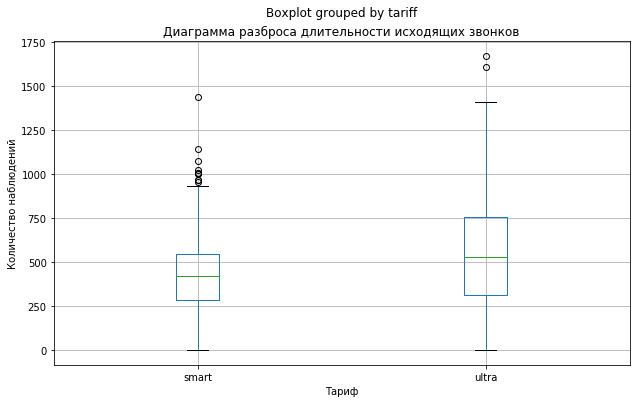

In [55]:
ax = report.boxplot(column=['duration_full'], by=['tariff'], figsize=(10,6))
ax.set_title('Диаграмма разброса длительности исходящих звонков')
ax.set_ylabel('Количество наблюдений')
ax.set_xlabel('Тариф')

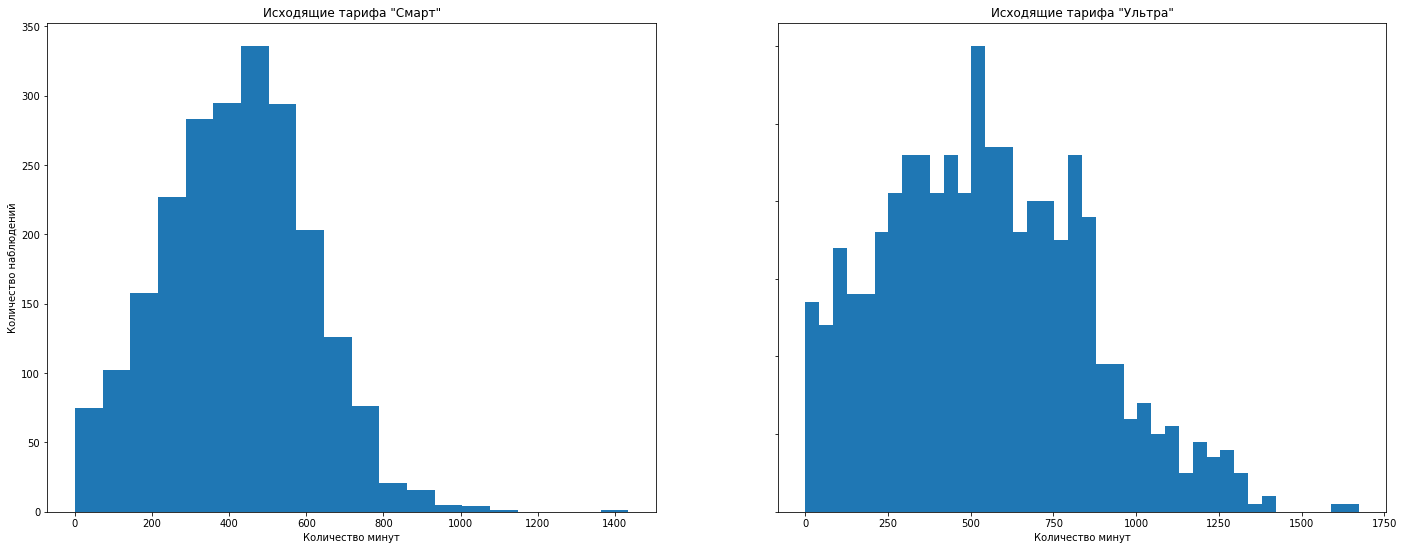

In [56]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(24,9))
ax1.hist(report.query('tariff == "smart"')['duration_full'], bins=20)
ax1.set_title('Исходящие тарифа "Смарт"')
ax1.set_ylabel('Количество наблюдений')
ax1.set_xlabel('Количество минут')
ax2.hist(report.query('tariff == "ultra"')['duration_full'], bins=40)
ax2.set_title('Исходящие тарифа "Ультра"')
ax2.set_xlabel('Количество минут')


for ax in fig.get_axes():
    ax.label_outer()

На тарифе "Смарт" распределение очень похоже на нормальное, дисперсия в сравнении с тарифом "Ультра" небольшая.

/opt/conda/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Text(0.5, 0, 'Тариф')

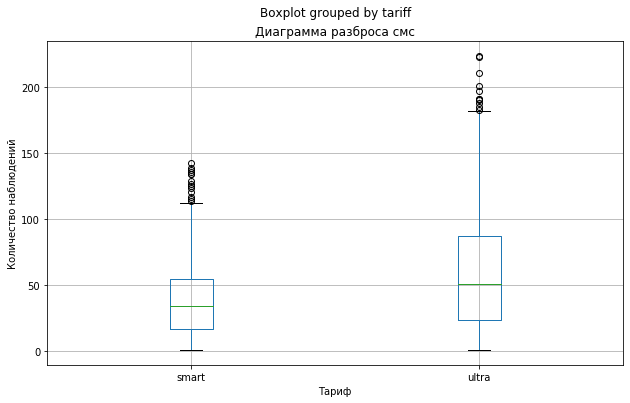

In [57]:
ax = report.boxplot(column=['msg_count'], by=['tariff'], figsize=(10,6))
ax.set_title('Диаграмма разброса смс')
ax.set_ylabel('Количество наблюдений')
ax.set_xlabel('Тариф')

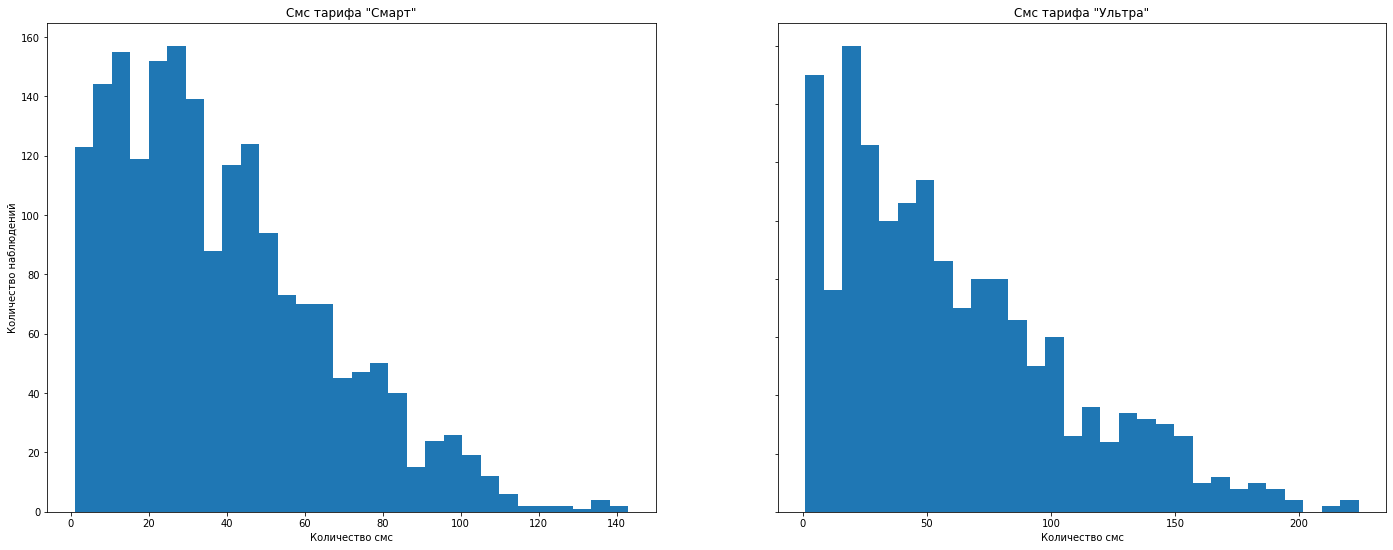

In [58]:
fig, (ax3, ax4) = plt.subplots(ncols=2, figsize=(24,9))
ax3.hist(report.query('tariff == "smart"')['msg_count'], bins=30)
ax3.set_title('Смс тарифа "Смарт"')
ax3.set_ylabel('Количество наблюдений')
ax3.set_xlabel('Количество смс')
ax4.hist(report.query('tariff == "ultra"')['msg_count'], bins=30)
ax4.set_title('Смс тарифа "Ультра"')
ax4.set_ylabel('Количество наблюдений')
ax4.set_xlabel('Количество смс')
for ax in fig.get_axes():
    ax.label_outer()

По использованным сообщениям колоколообразного распределения не получилось. Большое количество пользователей вовсе не пользуются отправкой смс.

/opt/conda/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Text(0.5, 0, 'Тариф')

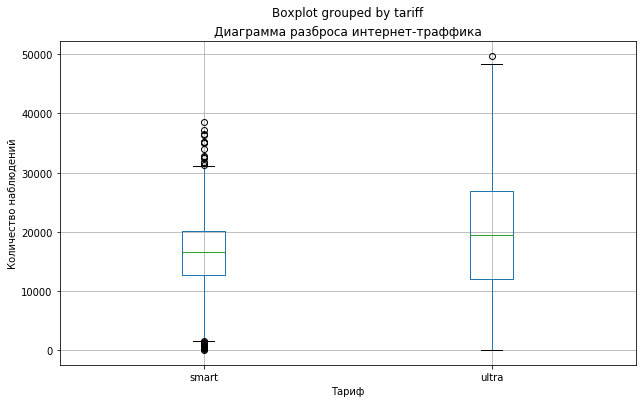

In [59]:
ax = report.boxplot(column=['mb_used_full'], by=['tariff'], figsize=(10,6))
ax.set_title('Диаграмма разброса интернет-траффика')
ax.set_ylabel('Количество наблюдений')
ax.set_xlabel('Тариф')

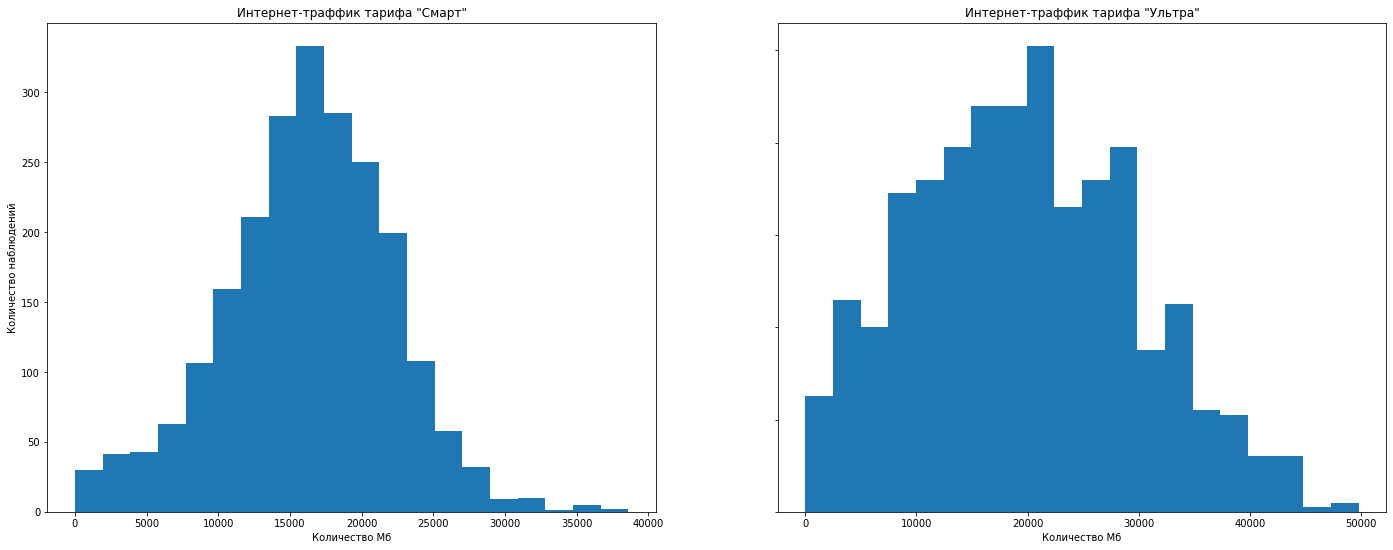

In [60]:
fig, (ax5, ax6) = plt.subplots(ncols=2, figsize=(24,9))
ax5.hist(report.query('tariff == "smart"')['mb_used_full'], bins=20)
ax5.set_title('Интернет-траффик тарифа "Смарт"')
ax5.set_ylabel('Количество наблюдений')
ax5.set_xlabel('Количество Мб')
ax6.hist(report.query('tariff == "ultra"')['mb_used_full'], bins=20)
ax6.set_title('Интернет-траффик тарифа "Ультра"')
ax6.set_ylabel('Количество наблюдений')
ax6.set_xlabel('Количество Мб')
for ax in fig.get_axes():
    ax.label_outer()

Интернет-траффик на тарифе "Смарт" снова имеет вид нормального распределения с пиком, превышающим размер предоставляемого на тарифе пакета. Пользователи тарифа "Ультра" имеют более разнообразные потребности в интернете.

В целом гистограммы для тарифа "Смарт" могут выглядеть более равномерными из-за большего количества наблюдений.

Далее детально рассмотрим, чем отличается прибыль оператора на разных тарифах.

In [61]:
pivot_rev = report.pivot_table(index='tariff', values='revenue',
                                aggfunc=['count', 'median', 'mean', np.var, np.std])
pivot_rev.columns = ['count', 'median', 'mean', 'variance', 'std']
pivot_rev

,count,median,mean,variance,std
tariff,,,,,
smart,2230,1037.0,1294.305381,673877.623614,820.900496
ultra,986,1950.0,2070.943205,143360.429258,378.629673


Пользователи тарифа "Смарт" в среднем тратят в 2 с небольшим раза больше, чем стоимость самого тарифа, а пользователи тарифа "Ультра" - всего на 6% больше.

Узнаем, как отличается суммарная месячная прибыль в зависимости от тарифа.

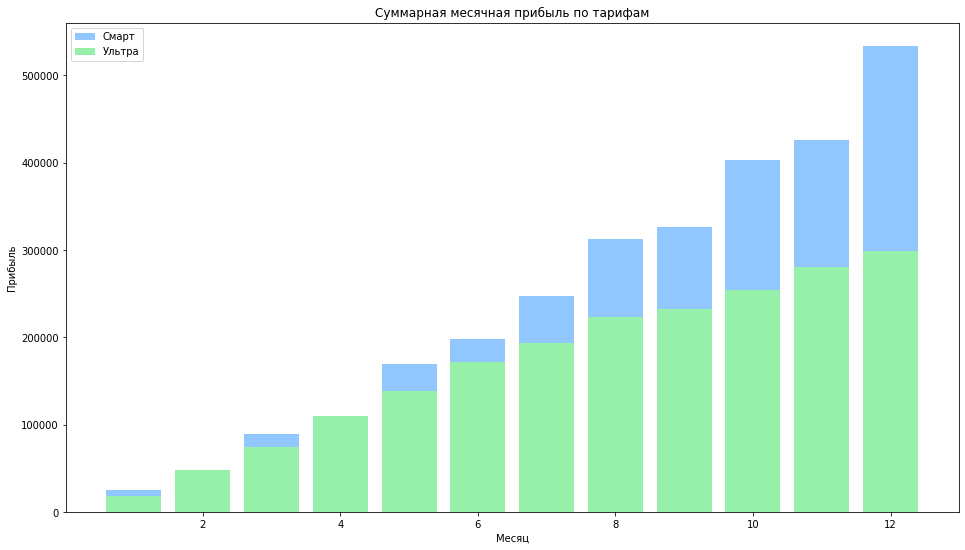

In [62]:
matplotlib.style.use('seaborn-pastel')
fig, ax = plt.subplots(figsize=(16,9))

ax.bar(report['month'].unique(), report.query('tariff == "smart"').groupby('month')['revenue'].sum(), label='Смарт')
ax.bar(report['month'].unique(), report.query('tariff == "ultra"').groupby('month')['revenue'].sum(), label='Ультра')

ax.set_ylabel('Прибыль')
ax.set_title('Суммарная месячная прибыль по тарифам')
ax.set_xlabel('Месяц')
ax.legend()

Все месяцы, кроме февраля и апреля тариф "Смарт" приносил больше прибыли. Отчасти это связано с тем, что это более массовый тариф.

Посчитаем суммарную прибыль за отчетный период для каждого тарифа:

In [63]:
report.query('tariff == "smart"')['revenue'].sum(), report.query('tariff == "ultra"')['revenue'].sum()

(2886301.0, 2041950.0)

In [64]:
report.query('tariff == "smart"')['revenue'].sum() / report.query('tariff == "ultra"')['revenue'].sum()

1.4135022894781948

Тариф "Смарт" принес на 41% прибыли больше.

Теперь посмотрим на динамику средней прибыли с пользователя за месяц в зависимости от тарифа.

Text(0.5, 0, 'Месяц')

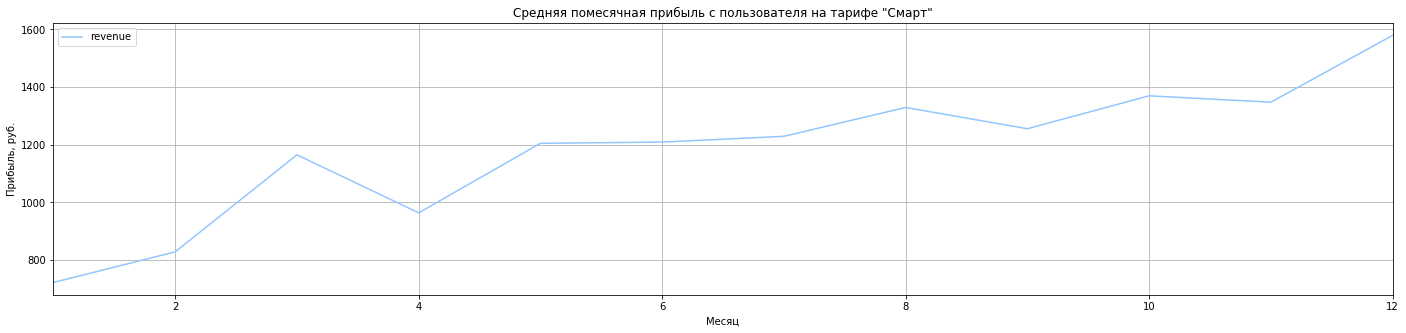

In [65]:
ax = (report
         .query('tariff == "smart"')
         .pivot_table(index='month', values='revenue')
         .plot(grid=True, figsize=(24,5))

)
ax.set_title('Средняя помесячная прибыль с пользователя на тарифе "Смарт"')
ax.set_ylabel('Прибыль, руб.')
ax.set_xlabel('Месяц')

В течение года расходы на связь у пользователей тарифа "Смарт" росли, с небольшим падением в апреле. К декабрю средняя прибыль с пользователя достигла отметки в 1600 рублей - почти в 3 раза выше стоимости тарифа и всего на 350 рублей меньше более дорогого тарифа "Ультра".

Text(0.5, 0, 'Месяц')

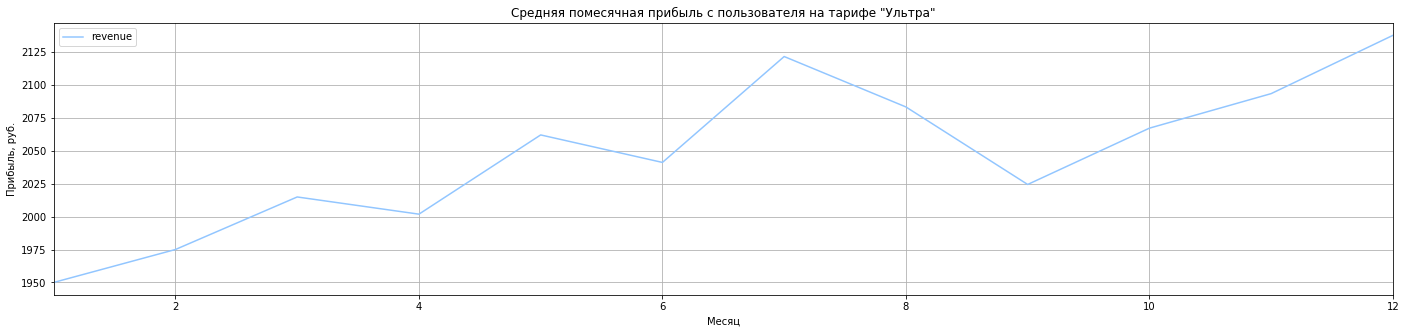

In [66]:
ax = (report
         .query('tariff == "ultra"')
         .pivot_table(index='month', values='revenue')
         .plot(grid=True, figsize=(24,5))

)
ax.set_title('Средняя помесячная прибыль с пользователя на тарифе "Ультра"')
ax.set_ylabel('Прибыль, руб.')
ax.set_xlabel('Месяц')

Средняя прибыль с пользователя на тарифе "Ультра" тоже росла с течением года, но не так стабильно. Каждые 2-3 месяца наблюдаются небольшие спады. К декабрю средняя прибыль достигла около 2150 рублей, что незначительно превышает базовую стоимость тарифа.

<a id="sum_up_3"></a>
**Вывод**

- Для большинства клиентов достаточно пакетов минут и смс тарифа "Смарт"
- Пользователи тарифа "Ультра" в отличие от пользователей тарифа "Смарт" никогда не превышают лимитов пакетов минут и смс
- Активнее всего пользуются интернетом. Пользователи тарифа "Смарт" вовсе в среднем вынуждены расходовать дополнительные пакеты интернет-траффика
- Пользователи тарифа "Смарт" тратят на связь значительно больше базовой ставки тарифа, к концу года в среднем прибыль с пользователя тарифа почти в 3 раза превышала стоимость самого тарифа
- Пользователи тарифа "Ультра" в среднем тоже тратят больше базовой ставки, но незначительно - до 10%.

<a id="hypotheses"></a>
## Проверка гипотез

Проверим следующие гипотезы:

- средняя выручка пользователей тарифов «Ультра» и «Смарт» различается;
- средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.

Поскольку выборки по тарифам у нас небольшие, то p-value возьмем 1%.

Имеем две независимые выборки с разной дисперсией. По сути, для проверка гипотезы заключается в том, чтобы проверить, различаются ли средние у этих двух выборок. Используем соответствующий тест.

В первом случае нулевую гипотезу сформулируем следующим образом: "Средняя выручка пользователей тарифов "Ультра" и "Смарт" не различается. Соответственно альтернативная гипотеза заключается в том, что средняя выручка на разных тарифах разная.

In [68]:
np.var(report.query('tariff == "smart"')['revenue']) / np.var(report.query('tariff == "ultra"')['revenue'])

4.703245328974121

Дисперсии различаются почти в 5 раз, поэтому тест запустим с параметром `equal_var` равным `False`, поскольку дисперсии не равны.

In [69]:
alpha = .01
    
results = st.ttest_ind(
    report.query('tariff == "smart"')['revenue'], 
    report.query('tariff == "ultra"')['revenue'],
    equal_var=False)

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 

p-значение: 1.2414049931248708e-246
Отвергаем нулевую гипотезу


Теперь узнаем, тратят ли в Москве на связь больше, чем в других городах. Нулевая гипотеза:"В Москве пользователи тратят на связь столько же, сколько и в других городах".

In [70]:
np.var(report.query('city == "Москва"')['revenue']) / np.var(report.query('city != "Москва"')['revenue'])

0.8610860513186547

Дисперсии неа равны, поскольку различаются более, чем на 5%, поэтому параметр`equal_var` в этом тесте также используем со значением `False`.

In [71]:
alpha = .01
    
results = st.ttest_ind(
    report.query('city == "Москва"')['revenue'], 
    report.query('city != "Москва"')['revenue'],
    equal_var=False)

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.5086199993481282
Не получилось отвергнуть нулевую гипотезу


<a id="sum_up_4"></a>
**Вывод**

- Выручка от пользователей разных тарифов различается
- Выручка от московских пользователей такая же как от пользователей в других городах.

<a id="sum_up"></a>
## Общий вывод

Мы проанализировали выборку пользователей двух тарифов мобильного оператора и определили, какой тариф приносит больше прибыли оператору.

- Для большинства пользователей единственной услугой, по которой лимиты имеют реальную значимость, является интернет
- Среднемесячная прибыль от пользователя тарифа "Ультра" выше, чем от пользователя тарифа "Смарт"
- В Москве пользователи оператора тратят не больше, чем в других городах
- Суммарная прибыль в выборке от пользователей тарифа "Смарт" превысила на 41% прибыль от пользователей тарифа "Ультра"
- Пользователи тарифа "Смарт" в среднем приносят прибыль в 2 раза выше, чем стоимость тарифа, а к декабрю 2018 года в среднем стали приносить почти в 3 раза больше стоимости тарифа
- На тарифе "Ультра" пользователи в среднем переплачивают сверх стоимости тарифа не более 10%.